In [1]:
# 전처리된 데이터 가져오기

import numpy as np
import pandas as pd

path = '/Users/jsha/gjai/final_project/black_swan_physionet/'
file = 'train_done_preprocessing.csv'
file2 = 'valid_done_preprocessing.csv'
file3 = 'test_done_preprocessing.csv'

train_df = pd.read_csv(path+file)
valid_df = pd.read_csv(path+file2)
test_df = pd.read_csv(path+file3)

maxlen = len(train_df[train_df['pid'] == train_df['pid'][0]])

print(len(test_df))
test_df.head()

28000


,pid,age,Gender,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,...,MBP,male,female,surv_los,LOS,labels,ICUType_1.0,ICUType_2.0,ICUType_3.0,ICUType_4.0
0,135089.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-7.0,6.0,0.0,0,0,1,0
1,135089.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-7.0,6.0,0.0,0,0,1,0
2,135089.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-7.0,6.0,0.0,0,0,1,0
3,135089.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-7.0,6.0,0.0,0,0,1,0
4,135089.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-7.0,6.0,0.0,0,0,1,0


In [2]:
# labels 컬럼 인덱스 찾기
inx = test_df.columns.get_indexer(['labels'])
print(inx)

# X, y 분리
y_test = test_df['labels']
X_test_nonorm = test_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_test.shape)
print(X_test_nonorm.shape)

# minmaxscaler 적용
import pickle

mms = 'mms.pickle'
with open(path+mms, 'rb') as handler:
    load_mms = pickle.load(handler)
    
X_test = load_mms.transform(X_test_nonorm)

X_test_3d = X_test.reshape((-1, maxlen, X_test.shape[-1]))
print(X_test_3d.shape)
y_test_3d = y_test[::maxlen]
print(y_test_3d.shape)

[41]
(28000,)
(28000, 40)
(400, 70, 40)
(400,)


In [3]:
# 학습된 Best models 가져오기
import os
from tensorflow.keras.models import load_model
import lightgbm as lgb

path = '/Users/jsha/gjai/final_project/black_swan_physionet/'
file_list = os.listdir()
deep_model_list = [file for file in file_list if file.endswith('_upto.h5')]
machine_model_list = [file for file in file_list if file.endswith('_machine.h5')]
print(deep_model_list)
print(machine_model_list)

# 모델별 X_test predict하고, test_df에 column 저장하기
for name in machine_model_list:
    loaded_model = lgb.Booster(model_file=name)
    test_pred = loaded_model.predict(X_test)
    
    test_df[f'{name}_pred'] = test_pred

for name in deep_model_list:
    loaded_model = load_model(path+name)
    test_pred = loaded_model.predict(X_test_3d)
    
    for i, pid in enumerate(list(test_df.pid.unique())):
        test_df.loc[test_df.query('pid==@pid').index, f'{name}_pred'] = test_pred[i][0]
        

['simple_model_best_upto.h5', 'api_model_best_upto.h5', 'cnn_model_best_upto.h5', 'lstm_model_best_upto.h5', 'bidirec_model_best_upto.h5']
['lgb_model_best_upto_machine.h5']


2022-11-30 14:48:38.951568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


13/13 [==============================] - 1s 14ms/step


In [4]:
test_df.head()

,pid,age,Gender,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,...,ICUType_1.0,ICUType_2.0,ICUType_3.0,ICUType_4.0,lgb_model_best_upto_machine.h5_pred,simple_model_best_upto.h5_pred,api_model_best_upto.h5_pred,cnn_model_best_upto.h5_pred,lstm_model_best_upto.h5_pred,bidirec_model_best_upto.h5_pred
0,135089.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0.137541,0.243371,0.28191,0.308481,0.30954,0.242593
1,135089.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0.137541,0.243371,0.28191,0.308481,0.30954,0.242593
2,135089.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0.137541,0.243371,0.28191,0.308481,0.30954,0.242593
3,135089.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0.137541,0.243371,0.28191,0.308481,0.30954,0.242593
4,135089.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0.137541,0.243371,0.28191,0.308481,0.30954,0.242593


Text(0, 0.5, 'True Positive Rate(Positive label: 1)')

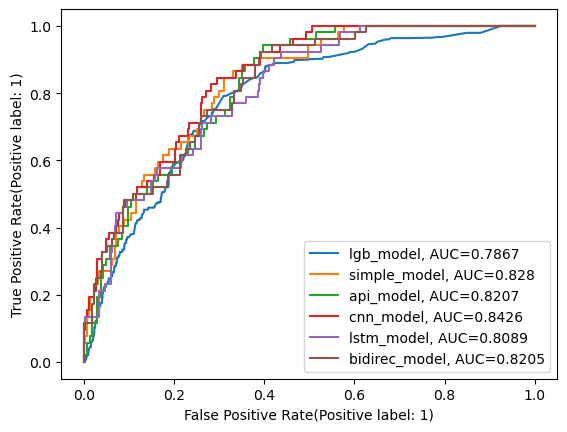

In [15]:
# 모델 간 roc_curve 비교하기

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

auc_score_dict = {}
model_pred_list = [col for col in test_df.columns.to_list() if col.endswith('pred')]
for name in model_pred_list:
    fpr, tpr, _ = roc_curve(y_test, test_df[name])
    auc = round(roc_auc_score(y_test, test_df[name]), 4)
    name2 = '_'.join(name.split('_')[:2])
    auc_score_dict[name2] = auc
    plt.plot(fpr, tpr, label=f"{name2}, AUC="+str(auc))
    
plt.legend()
plt.xlabel('False Positive Rate(Positive label: 1)')
plt.ylabel('True Positive Rate(Positive label: 1)')


In [19]:
# 모든 모델 pred 평균값으로 auroc score 구하기

test_df['models_pred_mean'] = test_df[model_pred_list].mean(axis=1)
auc_mean = round(roc_auc_score(y_test, test_df.models_pred_mean), 4)

auc_score_dict['mean_all_models'] = auc_mean

print(f'auroc_score of mean of all models: {auc_mean}')


auroc_score of mean of all models: 0.8341


In [7]:
np.mean([3,4,5])

4.0